# Анализ А/А теста (CTR)

## Общие данные и цели исследования

Имеются данные А/А-теста (группы 2 и 3) с '2023-08-22' по '2023-08-28', необходимо сделать симуляцию 10000 А/А-тестов из существующих выборок (по 500 уникальных пользователей в каждой группе на 1 симуляцию). Провести сравнение этих подвыборок t-тестом.

Далее требуется
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному А/А-тесту, корректно ли работает система сплитования.

							
Стуктура данных
- user_id - уникальный идентификатор пользователя
- post_id - уникальный идентификатор поста
- action - действие (просмотр/лайк)
- time - дата и время действия
- gender - гендер
- age - возраст
- country - страна
- city - город
- os - операционная система
- source - источник откуда пришел пользователь
- exp_group - номер группы тестирования

## Блок общих функций и импорта библиотек

In [1]:
#импорт из стандартной библиотеки

#импорт сторонних библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import pandahouse as ph
#from sklearn import preprocessing

Создадим класс для подключения к БД и получения результатов запроса

In [2]:
class getch:
    def __init__(self, query, db=''):
        self.connection = {
            'host': '',
            'password': '',
            'user': '',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = ph.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

## Загрузка данных и подготовка их к исследованию

Загрузим первую строку, и посмотрим на структуру БД

In [3]:
head_of_db = getch('SELECT * FROM {db}.feed_actions limit 1')

In [4]:
head_of_db.df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,106791,76,view,2023-08-02 00:26:19,0,45,Russia,Chelyabinsk,iOS,ads,3


Напишем запрос с целью получить агрегированные данные по просмотрам, лайкам, ctr, для каждого пользователя. Рассматриваемый промежуток времени 2023.08.22 - 2023.08.28

In [5]:
aagroup = getch('''
    SELECT user_id,
    countIf(action='like') as like,
    countIf(action='view') as view,
    exp_group,
    like / view as ctr
    FROM {db}.feed_actions 
    where exp_group between 2 and 3
        and toDate(time) between '2023-08-22' and '2023-08-28'
    group by user_id, exp_group
    ''') 

Посмотрим на общие данные в полученном датафрейме, а так же проверим на полные дубликаты все строчки.

In [6]:
aagroup.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    16787 non-null  uint32 
 1   like       16787 non-null  uint64 
 2   view       16787 non-null  uint64 
 3   exp_group  16787 non-null  int8   
 4   ctr        16787 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 475.5 KB


In [7]:
aagroup.df.duplicated().sum()

0

Посчитаем количество пользователей в каждой группе

In [8]:
aagroup.df['exp_group'].value_counts()

exp_group
3    8425
2    8362
Name: count, dtype: int64

Итого: у нас имеется 16787 записей, которые делятся на две группы.
1. Группа 3 - включает в себя 8425 записей
2. Группа 2 - включает в себя 8362 записи

Проверим количество пользователей попавших в две группы

In [9]:
aagroup.df['user_id'].value_counts().where(lambda x: x > 1).dropna().sort_values(ascending=False)

Series([], Name: count, dtype: float64)

Количество пользователей оказавшихся в двух группах равно 0

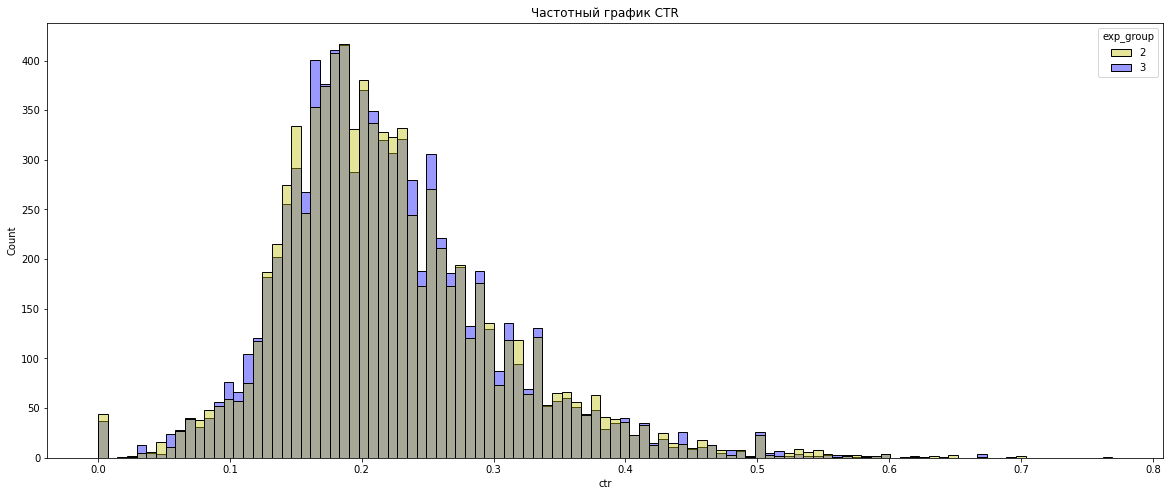

In [10]:
plt.figure(figsize=(20,8))
plt.title('Частотный график CTR')
sns.histplot(data=aagroup.df[['ctr', 'exp_group']],x='ctr', hue='exp_group', palette = ['y', 'b'], alpha = 0.4);

Проведем симуляцию 10 000 А/А тестов на базе группы 2 и 3. Для этого при каждой итерации случайно будем формировать подвыборки по 500 пользователей из группы 2 и 3 и сравнить их средний CTR t-тестом. Создадим список, включающий все полученные p-value, и далее посмотрим как много p-value оказалось ниже или равно 0.05.
- H0 - средние между группами равны
- H1 - средние между группами не равны

In [11]:
p_value_list = []
test_cnt = 10000
group_sample = 500

In [12]:
for i in range(0, test_cnt): 
    p_value_list.append(st.ttest_ind(
        aagroup.df.query('exp_group == 2').sample(group_sample, random_state=i)['ctr'], 
        aagroup.df.query('exp_group == 3').sample(group_sample, random_state=i)['ctr'], 
        equal_var=False
    )[1])

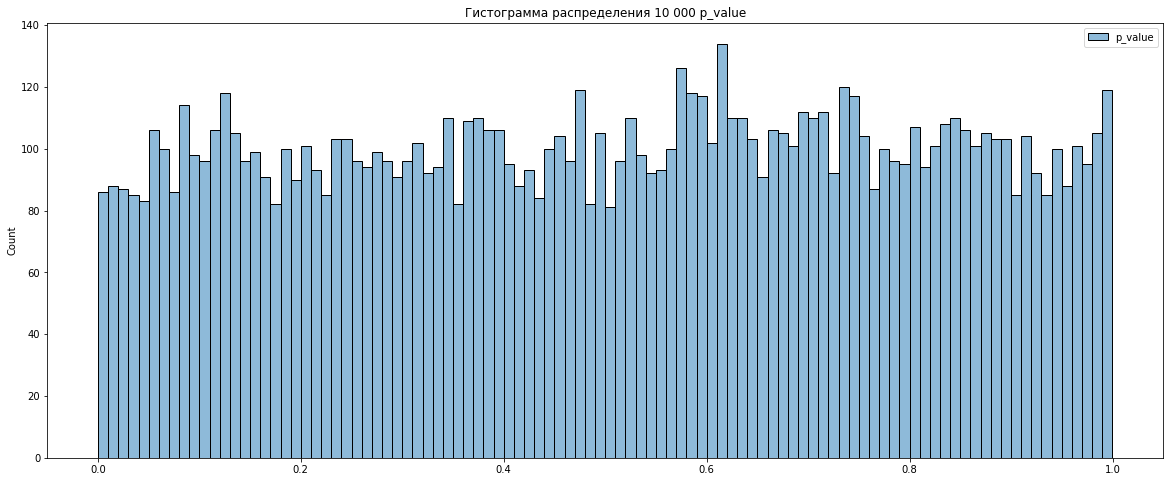

In [13]:
plt.figure(figsize=(20,8))
plt.title('Гистограмма распределения 10 000 p_value')
sns.histplot(data = pd.DataFrame(p_value_list, columns=['p_value']), bins=100);

Посчитаем какой тестов оказался меньше или равен 0.05

In [14]:
print(
    'При проведении 10 000 тестов по сравнению средних CTR из подвыборок 500 уникальных пользователей', 
    (pd.DataFrame(p_value_list, columns=['p_value']).query('p_value <= 0.05').agg('count').values[0] / test_cnt) * 100, 
    'процентов тестов показало статистически значимую разницу между подгруппами (средние не были равны)'
)

При проведении 10 000 тестов по сравнению средних CTR из подвыборок 500 уникальных пользователей 4.29 процентов тестов показало статистически значимую разницу между подгруппами (средние не были равны)


Проверим равенство средних t-тестом между всей группой 2 и группой 3
1. H0 - средние между группами равны
2. H1 - средние между группами не равны

a=0.05

In [15]:
a=0.05
p_value_group_2_3 = st.ttest_ind(
                                aagroup.df.query('exp_group == 2')['ctr'], 
                                aagroup.df.query('exp_group == 3')['ctr'], 
                                equal_var=False
                            )[1]

if p_value_group_2_3 <=0.5:
    print(f'p_value = {round(p_value_group_2_3, 2)}, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной')
else:
    print(f'p_value = {round(p_value_group_2_3, 2)}, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной')

p_value = 0.51, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной


## ВЫВОД

После проведенных тестов и симуляции можно сделать вывод что:
1. Группы получились более менее равного размера
2. При проведении 10 000 симуляций А/А теста, менее 5% тестов показали статистически значимую разницу между группами, при установленном уровне стат.значимости 0.05
3. При сравнении двух выборок целиком было получено p_value = 0.51, что не позволяет отвергнуть нулевую гипотезу о равенстве средних 
4. Система сплитирования работает корректно